##  Warm-up: Basic deterministic under-sampling
In this first notebook, we start with simple deterministic under-sampling using either a low-frequency or a high-frequency mask. Hence we want to generate a sampling mask $\Omega\in\{0,1\}^N$ such that $y = F_{\Omega} x$ where $x\in R^{N}$ is the original image. The data $y$ is then corrupted by additive noise $b$: 
$$
y = F_{\Omega} x + b
$$
where $b$ is a complex-valued circular Gaussian noise of variance $\sigma^2$ and $F_{\Omega} = \Omega F$ in this **Cartesian** setting (i.e. sampling on the grid).
We consider:
1.  a low-frequency Cartesian mask $\Omega$ is defined by the central lines of k-space. 
2.  a low-frequency Cartesian mask $\Omega$ is defined by a square box in k-space centered at $(k_x,k_y)=(0,0)$. 
3.  a high-frequency Cartesian mask $\Omega$ is defined as the complementary set of the lines defined in to 1)
4.  a high-frequency Cartesian mask $\Omega$ is defined as the complementary set of the box defined in 2)

Based on these masks we generate the corresponding measured data from a reference MR image and finally perform Cartesian image reconstruction $\widehat{x}$ from the under-sampled data $y$ as follows:
$$
\widehat{x} = \tilde{F}^* y
$$
where $F^*$ is the zero-filled inverse Fourier transform (ifft). 

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 04/01/2019
- Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
- **Revisions**: 01/03/2022 and 01/05/2021 for ATSI MSc hands-on session at Paris-Saclay University.

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline
import sys
import os.path as op
import os
import math
import cmath

import numpy as np

import matplotlib.pyplot as plt

from skimage import data, io

# get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd, "../data")
img_size = 512   #256
FOV = 0.2 #field of view in m
pixelSize = FOV/img_size

# load data file corresponding to the target resolution
filename = "BrainPhantom%s.png" % img_size
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename)

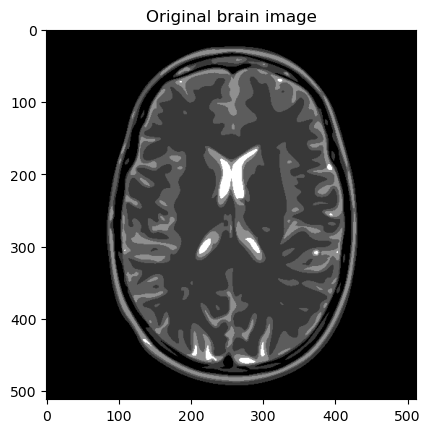

In [2]:
plt.figure()
plt.title("Brain Phantom, size = %s " % img_size)
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.title("Original brain image")
plt.show()
#plt.close()

(512, 512)


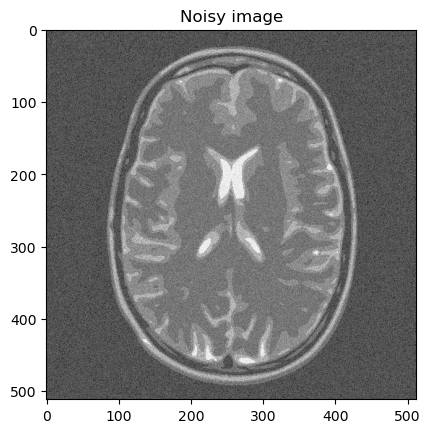

In [3]:
# Plot Noisy image
new_img = np.copy(mri_img.astype('float64'))
new_img += np.random.randn(*mri_img.shape) * 20
print(mri_img.shape)

if 1:
    plt.figure()
    plt.imshow(new_img, cmap='Greys_r')
    plt.title("Noisy image")
    plt.savefig(op.join(cwd, "brain.jpg"))
    plt.show()

* To start up, the objective is to construct a low-frequency sampling mask that consists of the central k-space lines
* Fourier transform the reference MR image to compute k-space data, add zero-mean Gaussian complex-valued noise
* Mask the data using the above defined mask
* Next, perform zero-filled MR image reconstruction from masked k-space data 
* Study the impact of the number of lines in the mask on the final image quality 

In [4]:
# Generate trivial Cartesian sampling masks
img_size = 512

mask="low_res"
factor_ctr = 8

#Objective: construct a k-space mask that consists of the central lines
# 0 entries: points not sampled, 1 entries: points to be sampled
# Initialize k-space with 0 everywhere and then place the "1" appropriately
kspace_masklines = np.zeros((img_size,img_size), dtype="float64")

In [5]:
512 / 8

64.0

In [6]:
low_res_size = img_size // factor_ctr + 1
low_res_size

65

In [8]:
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size)
idx_vec_ =  idx_vec.astype("int")
print(idx_vec_)

[224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288]


In [10]:
#Use fancy indexing to select low frequency lines only
kspace_masklines[idx_vec_, ] = 1

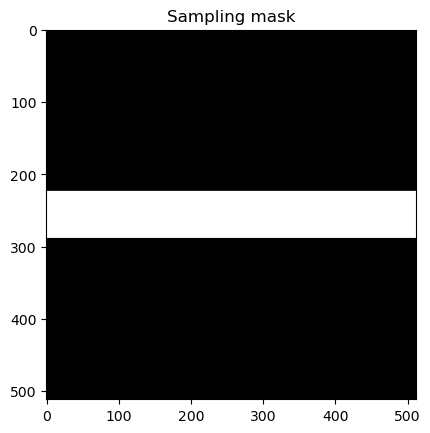

In [11]:

#if 0: # to debug
#    vec =  np.array([idx_vec.astype("int")])
#    zero_vfill = np.zeros((1, (img_size-low_res_size) // 2), dtype="int")
#    line_vec = np.concatenate((zero_vfill, vec, zero_vfill), axis=1)
#    center_lines = np.tile(line_vec, (low_res_size, 1))
#    kspace_mask[center_lines] =1.

if 1:
    plt.figure()
    plt.imshow(kspace_masklines, cmap='Greys_r')
    plt.title("Sampling mask")
    plt.show()

norm = "ortho"
#norm = None

In [22]:

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)

In [40]:
kspace_data.shape

(512, 512)

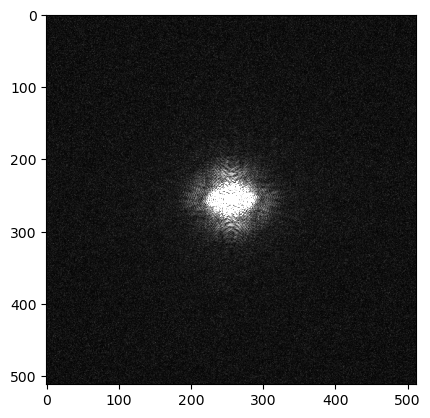

In [43]:
plt.imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())

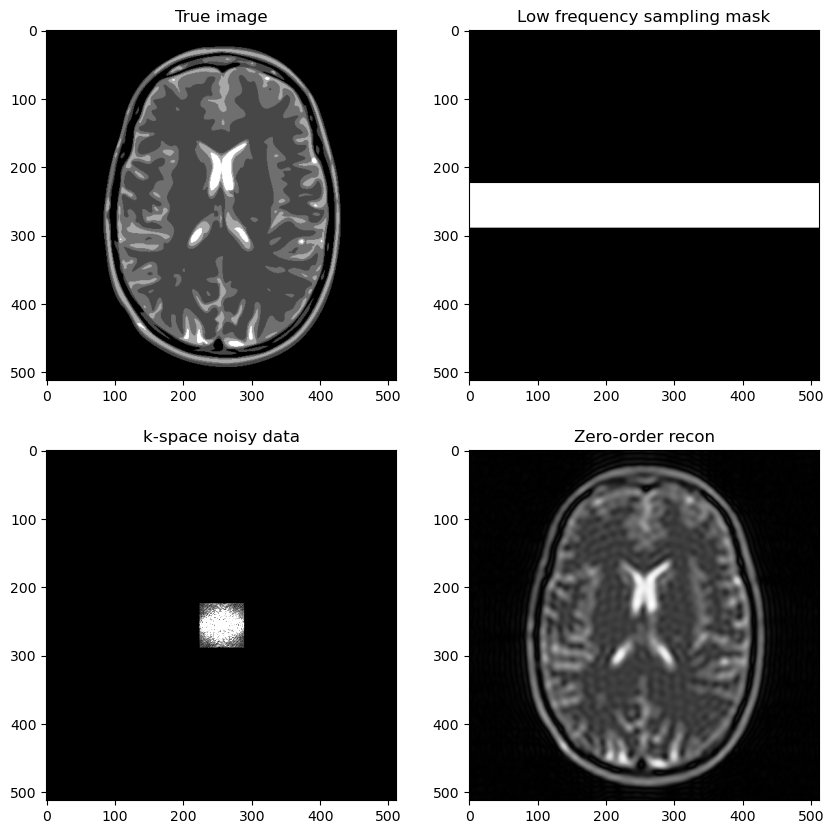

In [24]:

# Mask data to perform subsampling
kspace_data *= kspace_masklines

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))            # get back to the convention

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_masklines, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

* Question: based on the previous example, try to construct a low-freqency sampling mask defined by a **square box** centered around $(k_x, k_y) = (0,0)$.
* Then, replicate the same steps: 
  1. Generate noisy masked data 
  2. Perform zero-filled MR image reconstruction
  3. Visualize results and study the impact of both the noise level and the mask size

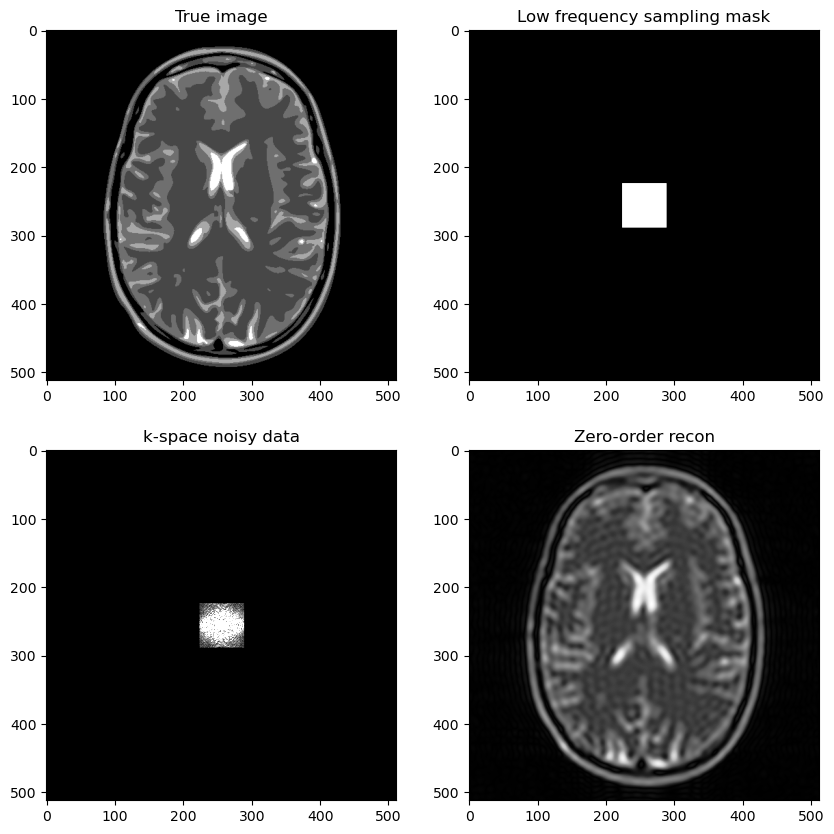

In [25]:
#Objective: construct a k-space mask consisting of a central box
# Initialize k-space with 0 everywhere and then place the "1" appropriately
kspace_maskbox = np.zeros((img_size,img_size), dtype="float64")
# use fancy indexing along rows
kspace_maskbox[idx_vec_, ] = 1

list_img_size = np.arange(0., img_size).tolist()
filtered_center = [x for x in list_img_size if x not in idx_vec_]
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")
# use fancy indexing along cols
kspace_maskbox[:, array_idx_center_] = 0

# Note that the combination of these two fancy indexing replaces the poor code below
#for i in idx_vec_:
#    for j in idx_vec_:
#        kspace_mask[i, j] = 1.

if 0:
    plt.figure()
    plt.imshow(kspace_maskbox, cmap='Greys_r')
    plt.title("Sampling mask")
    plt.show()

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_maskbox 

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_maskbox, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

* Next question: Construct a k-space sampling mask that consists of the high-frequency lines, just discard the central lines
* Study the impact of the number of lines removed 

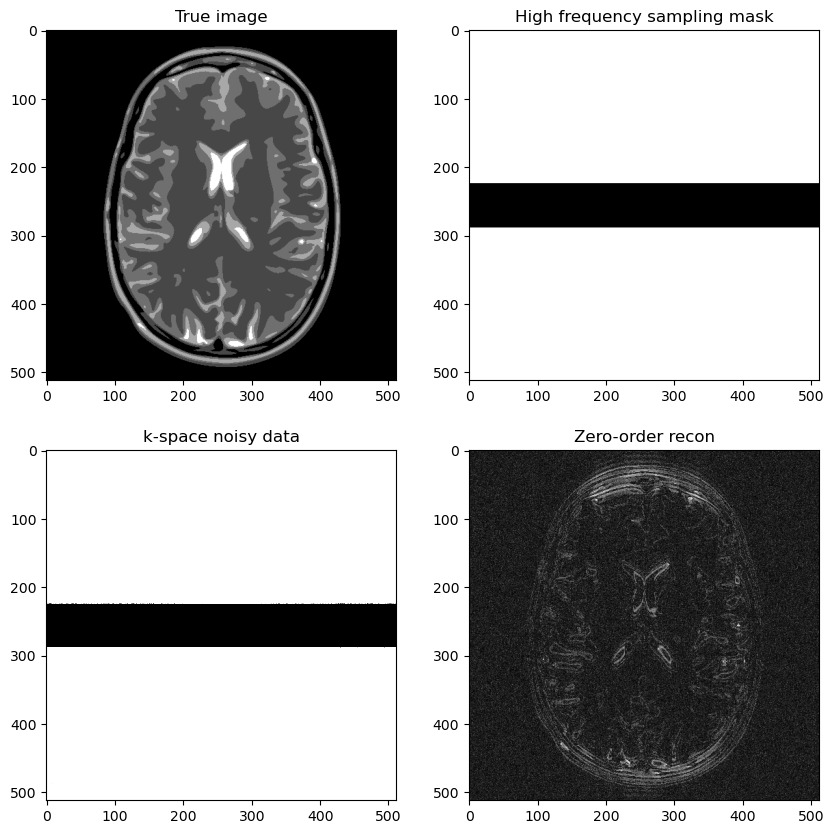

In [48]:
# 0 entries: points not sampled, 1 entries: points to be sampled
# Initialize k-space with "1" everywhere and then place the "0" appropriately

kspace_masklines = np.ones((img_size,img_size), dtype="float64")
#low_res_size = img_size // (factor_ctr // 2) + 1 
low_res_size = img_size // factor_ctr + 1
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size)
idx_vec_ =  idx_vec.astype("int")

# set central k-space lines to 0: use fancy indexing along rows
kspace_masklines[idx_vec_, ] = 0

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_masklines 

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))            # get back to the convention

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_masklines, cmap='Greys_r')
axs[0, 1].set_title("High frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

**Question**: Based on the previous example, try to construct a k-space mask that consists of the removing the central box centered in $(𝑘_𝑥,𝑘_𝑦)=(0,0)$.
* Then, replicate the same steps:
    1. Generate noisy masked data
    2. Perform zero-filled MR image recon
    3. Visualize results and study the impact of both the noise level and the mask size

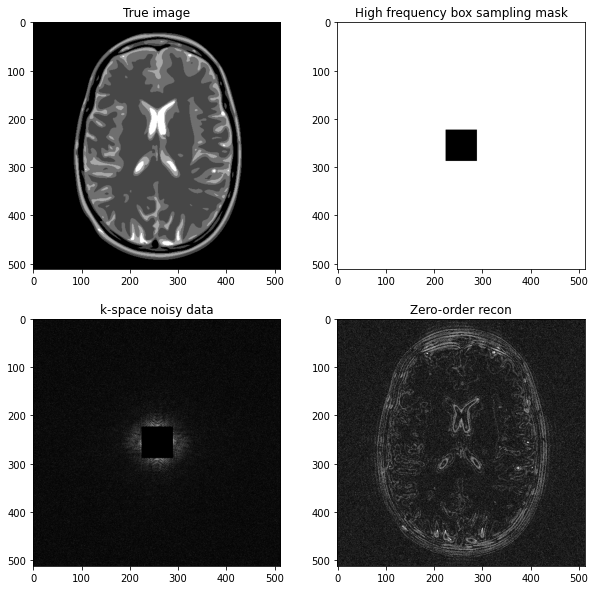

In [9]:
# 0 entries: points not sampled, 1 entries: points to be sampled
# Initialize k-space with "1" everywhere and then place the "0" appropriately
kspace_maskbox = np.ones((img_size,img_size), dtype="float64")
# use fancy indexing along rows
kspace_maskbox[idx_vec_, ] = 0

list_img_size = np.arange(0., img_size).tolist()
filtered_center = [x for x in list_img_size if x not in idx_vec_]
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")
# use fancy indexing along cols
kspace_maskbox[:, array_idx_center_] = 1

# Note that the combination of these two fancy indexing replaces the poor code below
#for i in idx_vec_:
#    for j in idx_vec_:
#        kspace_mask[i,j]=0.

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_maskbox 

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_maskbox, cmap='Greys_r')
axs[0,1].set_title("High frequency box sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=1*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data")
axs[1,1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()